## Approximate Nearest Neighbors

#### 01. Import SectionNearest Neighbors

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle


from utils import save_dataset, load_dataset
from prep_utils import wrapper_dict2tensor, wrapper_cast
import time

#### 02. Sample data

In [44]:
class random_community():
    def __init__(self, mu, sigma, sample_size, embedding_size, community_id):
        self._mu = mu
        self._sigma = sigma
        self._sample_size = sample_size
        self._embedding_size = embedding_size
        
        assert type(community_id)==int
        self._id = community_id
        
        self.data = None
    
    def set_params(self, mu=None, sigma=None, size=None, embedding_size=None):
        if mu is not None:
            self._mu = mu
        if sigma is not None:
            self._sigma = sigma
        if size is not None:
            self._sample_size = sample_size
        if embedding_size is not None:
            self._embedding_size = embedding_size
            
    def generate_sample(self):
        self.data = {}
        self.data['embeddings'] = self._mu + self._sigma * np.random.randn(self._sample_size, self._embedding_size)
        self.data['labels'] = self._id*np.ones(self._sample_size)
        self.data['sample_id'] = [f'community_{self._id}-{i}' for i in range(self._sample_size)]
    
    def get_data(self):
        assert self.data is not None
        return self.data
    
    def get_id(self):
        return self._id

In [325]:
embedding_size = 2
community_params = [[1, 0.5, 100],
                    [0, 1, 50]]

communities = []
for _id, params in enumerate(community_params):
    tmp = random_community(*params, embedding_size, _id)
    tmp.generate_sample()
    communities.append(tmp)

In [326]:
data = {}
data['embeddings'] = []
data['labels'] = []
data['sample_id'] = []
for community in communities:
    community_data = community.get_data()
    data['embeddings'].extend(community_data['embeddings'])
    data['labels'].extend(community_data['labels'])
    data['sample_id'].extend(community_data['sample_id'])

In [327]:
# generate test_data
test_params = community_params[1][:2]
test_community = random_community(*test_params, 5, embedding_size, community_id=1)
test_community.generate_sample()

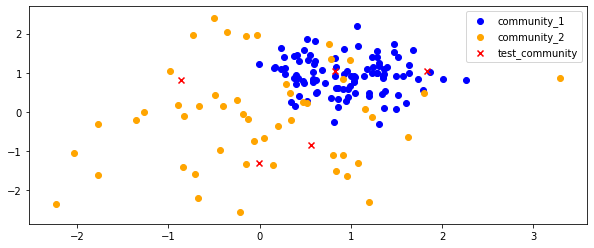

In [328]:
# plot results for two communities and test_community
plt.figure(figsize=(10,4))
plt.scatter(communities[0].get_data()['embeddings'][:,0], communities[0].get_data()['embeddings'][:,1], c='blue', label='community_1')
plt.scatter(communities[1].get_data()['embeddings'][:,0], communities[1].get_data()['embeddings'][:,1], c='orange', label='community_2')
# test community
plt.scatter(test_community.get_data()['embeddings'][:,0], test_community.get_data()['embeddings'][:,1], c='red', marker='x', label='test_community')

plt.legend()

plt.show()

In [329]:
def local_wrapper_cast(x, key):
    x[key] =  tf.cast(x[key], tf.float32)
    return x

In [330]:
AUTOTUNE = tf.data.AUTOTUNE

# build dataset similar to our embeddings - with labels
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.map(lambda x: local_wrapper_cast(x, 'embeddings'))

save_dataset(dataset.map(lambda x: wrapper_dict2tensor(x, features=['embeddings']), num_parallel_calls=AUTOTUNE), './samples_ann/embeddings.record')
save_dataset(dataset.map(lambda x: wrapper_dict2tensor(x, features=['labels']), num_parallel_calls=AUTOTUNE), './samples_ann/labels.record')


# create test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_community.get_data())
test_dataset = test_dataset.map(lambda x: local_wrapper_cast(x, 'embeddings'))

save_dataset(test_dataset.map(lambda x: wrapper_dict2tensor(x, features=['embeddings']), num_parallel_calls=AUTOTUNE), './samples_ann/test_embeddings.record')
save_dataset(test_dataset.map(lambda x: wrapper_dict2tensor(x, features=['labels']), num_parallel_calls=AUTOTUNE), './samples_ann/test_labels.record')

True

## Now we work on ANN

In [331]:
# !pip install annoy
import annoy

In [332]:
ann_metric = 'euclidean'
annoy_index = annoy.AnnoyIndex(embedding_size, metric=ann_metric)
mapping = {}

In [333]:
data_dir = './samples_ann'
embedding_files = "{}/embeddings.record".format(data_dir)

print(embedding_files)
timestr = time.strftime("%Y%m%d-%H%M%S")
index_filename = f"index_dir/index-{timestr}"

def _parse_example(x):
    return tf.io.parse_tensor(x, tf.float32)

./samples_ann/embeddings.record


In [334]:
def build_index(embedding_files_pattern, index_filename, vector_length, 
        metric='euclidean', num_trees=100):
    '''Builds an ANNOY index'''

    annoy_index = annoy.AnnoyIndex(vector_length, metric=metric)
    # Mapping between the item and its identifier in the index
    mapping = {}

    embed_files = tf.io.gfile.glob(embedding_files_pattern)
    num_files = len(embed_files)
    print('Found {} embedding file(s).'.format(num_files))

    item_counter = 0
    for i, embed_file in enumerate(embed_files):
        print('Loading embeddings in file {} of {}...'.format(i+1, num_files))
#         dataset = tf.data.TFRecordDataset(embed_file)
#         dataset=dataset
        for record in dataset: #dataset.map(_parse_example):
#             print(record)
            text = record['sample_id'].numpy().decode("utf-8")
            embedding = record['embeddings'].numpy()
            mapping[item_counter] = text
            annoy_index.add_item(item_counter, embedding)
            item_counter += 1
            if item_counter % 100000 == 0:
                print('{} items loaded to the index'.format(item_counter))

    print('A total of {} items added to the index'.format(item_counter))

    print('Building the index with {} trees...'.format(num_trees))
    annoy_index.build(n_trees=num_trees)
    print('Index is successfully built.')

    print('Saving index to disk...')
    annoy_index.save(index_filename)
    print('Index is saved to disk.')
    print("Index file size: {} GB".format(
        round(os.path.getsize(index_filename) / float(1024 ** 3), 2)))
    annoy_index.unload()

    print('Saving mapping to disk...')
    with open(index_filename + '.mapping', 'wb') as handle:
        pickle.dump(mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Mapping is saved to disk.')
    print("Mapping file size: {} MB".format(
        round(os.path.getsize(index_filename + '.mapping') / float(1024 ** 2), 2)))

In [335]:
# os.remove(index_filename)
# os.remove(index_filename+'.mapping')
%time build_index(embedding_files, index_filename, embedding_size, metric=ann_metric)

Found 1 embedding file(s).
Loading embeddings in file 1 of 1...
A total of 150 items added to the index
Building the index with 100 trees...
Index is successfully built.
Saving index to disk...
Index is saved to disk.
Index file size: 0.0 GB
Saving mapping to disk...
Mapping is saved to disk.
Mapping file size: 0.0 MB
Wall time: 75 ms


In [336]:
%time
index = annoy.AnnoyIndex(embedding_size, ann_metric)
index.load(index_filename, prefault=True)
print('Annoy index is loaded.')
with open(index_filename + '.mapping', 'rb') as handle:
    mapping = pickle.load(handle)
print('Mapping file is loaded.')

Wall time: 0 ns
Annoy index is loaded.
Mapping file is loaded.


In [337]:
def find_similar_items(embedding, num_matches=5):
    '''Finds similar items to a given embedding in the ANN index'''
    ids = index.get_nns_by_vector(
    embedding, num_matches, search_k=-1, include_distances=False)
    items = [mapping[i] for i in ids]
    return items

In [338]:
single_test_vector = list(test_dataset.as_numpy_iterator())[0]
print(single_test_vector['embeddings'])


[0.8236191 1.050405 ]


In [339]:
def exctract_closest_cloud(closest_indivuals):
    chosens = {}
    for i, individual in enumerate(closest_indivuals):
        community, member = individual.split('_')[1].split('-')
        chosens[i] = [int(community), int(member)]
    return chosens

In [343]:
%time closest_indivuals = find_similar_items(single_test_vector['embeddings'], num_matches=10)

closest_cloud = exctract_closest_cloud(closest_indivuals)

Wall time: 0 ns


In [344]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
%time neigh.fit(np.array(data['embeddings']), np.array(data['labels']))
%time k_neighbors = neigh.kneighbors(single_test_vector['embeddings'].reshape(-1, 2), return_distance=False)

Wall time: 0 ns


In [345]:
k_neighbors = k_neighbors.flatten()

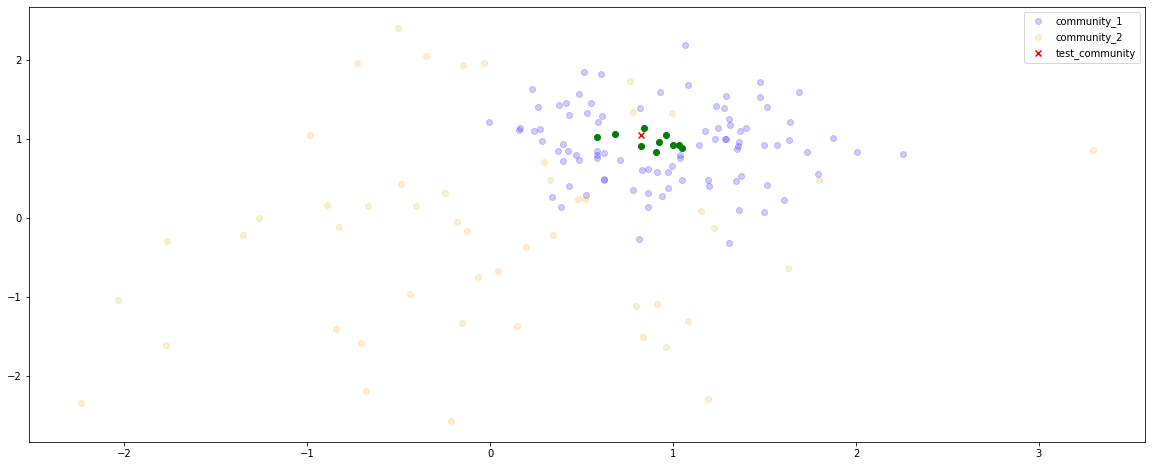

In [346]:
# plot results for two communities and test_community
plt.figure(figsize=(20,8))
plt.scatter(communities[0].get_data()['embeddings'][:,0], communities[0].get_data()['embeddings'][:,1], c='blue', label='community_1', alpha=0.2)
plt.scatter(communities[1].get_data()['embeddings'][:,0], communities[1].get_data()['embeddings'][:,1], c='orange', label='community_2', alpha=0.2)
# test community
plt.scatter(single_test_vector['embeddings'][0], single_test_vector['embeddings'][1], c='red', marker='x', label='test_community')
# closest
for point in closest_cloud.values():
    plt.scatter(communities[point[0]].get_data()['embeddings'][point[1],0], communities[point[0]].get_data()['embeddings'][point[1],1], c='green')

plt.legend()

plt.show()

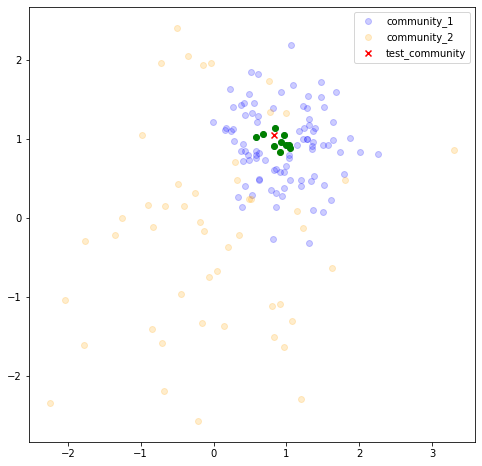

In [348]:
# plot results for two communities and test_community
plt.figure(figsize=(8,8))
plt.scatter(communities[0].get_data()['embeddings'][:,0], communities[0].get_data()['embeddings'][:,1], c='blue', label='community_1', alpha=0.2)
plt.scatter(communities[1].get_data()['embeddings'][:,0], communities[1].get_data()['embeddings'][:,1], c='orange', label='community_2', alpha=0.2)
# test community
plt.scatter(single_test_vector['embeddings'][0], single_test_vector['embeddings'][1], c='red', marker='x', label='test_community')
# closest
for point in k_neighbors:
    plt.scatter(data['embeddings'][point][0], data['embeddings'][point][1], c='green')

plt.legend()

plt.show()

## Next-Up: How do they perform on 1024-dim data? 

In [358]:
embedding_size = 1024
community_params = [[1, 0.2, 10000],
                    [0, 0.2, 20000]]

communities = []
for _id, params in enumerate(community_params):
    tmp = random_community(*params, embedding_size, _id)
    tmp.generate_sample()
    communities.append(tmp)

In [359]:
data = {}
data['embeddings'] = []
data['labels'] = []
data['sample_id'] = []
for community in communities:
    community_data = community.get_data()
    data['embeddings'].extend(community_data['embeddings'])
    data['labels'].extend(community_data['labels'])
    data['sample_id'].extend(community_data['sample_id'])

In [360]:
# generate test_data
test_params = community_params[1][:2]
test_community = random_community(*test_params, 5, embedding_size, community_id=1)
test_community.generate_sample()
test_community.get_data()

{'embeddings': array([[ 0.0194414 , -0.01170788,  0.15828995, ...,  0.31570143,
          0.01851687, -0.33540843],
        [ 0.03824445, -0.24797756,  0.31425252, ...,  0.04006774,
         -0.15028706, -0.41199227],
        [-0.05407442,  0.25931798, -0.04570635, ...,  0.0364051 ,
          0.02747045,  0.20566359],
        [-0.04919579,  0.16509743, -0.13208152, ..., -0.12121496,
          0.04128367, -0.19323731],
        [ 0.06154066,  0.00900953,  0.05425838, ..., -0.03264208,
          0.2295908 , -0.00143458]]),
 'labels': array([1., 1., 1., 1., 1.]),
 'sample_id': ['community_1-0',
  'community_1-1',
  'community_1-2',
  'community_1-3',
  'community_1-4']}

In [361]:
# # plot results for two communities and test_community
# plt.figure(figsize=(10,4))
# plt.scatter(communities[0].get_data()['embeddings'][:,0], communities[0].get_data()['embeddings'][:,1], c='blue', label='community_1')
# plt.scatter(communities[1].get_data()['embeddings'][:,0], communities[1].get_data()['embeddings'][:,1], c='orange', label='community_2')
# # test community
# plt.scatter(test_community.get_data()['embeddings'][:,0], test_community.get_data()['embeddings'][:,1], c='red', marker='x', label='test_community')

# plt.legend()

# plt.show()

In [362]:
def local_wrapper_cast(x, key):
    x[key] =  tf.cast(x[key], tf.float32)
    return x

In [363]:
AUTOTUNE = tf.data.AUTOTUNE

# build dataset similar to our embeddings - with labels
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.map(lambda x: local_wrapper_cast(x, 'embeddings'))




# create test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_community.get_data())
test_dataset = test_dataset.map(lambda x: local_wrapper_cast(x, 'embeddings'))

In [249]:
save_dataset(dataset.map(lambda x: wrapper_dict2tensor(x, features=['embeddings']), num_parallel_calls=AUTOTUNE), './samples_ann/embeddings.record')
save_dataset(dataset.map(lambda x: wrapper_dict2tensor(x, features=['labels']), num_parallel_calls=AUTOTUNE), './samples_ann/labels.record')
save_dataset(test_dataset.map(lambda x: wrapper_dict2tensor(x, features=['embeddings']), num_parallel_calls=AUTOTUNE), './samples_ann/test_embeddings.record')
save_dataset(test_dataset.map(lambda x: wrapper_dict2tensor(x, features=['labels']), num_parallel_calls=AUTOTUNE), './samples_ann/test_labels.record')

True

## Now we work on ANN

In [364]:
# !pip install annoy
import annoy

In [365]:
ann_metric = 'euclidean'
annoy_index = annoy.AnnoyIndex(embedding_size, metric=ann_metric)
mapping = {}

In [366]:
data_dir = './samples_ann'
embedding_files = "{}/embeddings.record".format(data_dir)

print(embedding_files)
timestr = time.strftime("%Y%m%d-%H%M%S")
index_filename = f"index_dir/index-{timestr}"

def _parse_example(x):
    return tf.io.parse_tensor(x, tf.float32)

./samples_ann/embeddings.record


In [367]:
def build_index(embedding_files_pattern, index_filename, vector_length, 
        metric='euclidean', num_trees=100):
    '''Builds an ANNOY index'''

    annoy_index = annoy.AnnoyIndex(vector_length, metric=metric)
    # Mapping between the item and its identifier in the index
    mapping = {}

    embed_files = tf.io.gfile.glob(embedding_files_pattern)
    num_files = len(embed_files)
    print('Found {} embedding file(s).'.format(num_files))

    item_counter = 0
    for i, embed_file in enumerate(embed_files):
        print('Loading embeddings in file {} of {}...'.format(i+1, num_files))
#         dataset = tf.data.TFRecordDataset(embed_file)
#         dataset=dataset
        for record in dataset: #dataset.map(_parse_example):
#             print(record)
            text = record['sample_id'].numpy().decode("utf-8")
            embedding = record['embeddings'].numpy()
            mapping[item_counter] = text
            annoy_index.add_item(item_counter, embedding)
            item_counter += 1
            if item_counter % 100000 == 0:
                print('{} items loaded to the index'.format(item_counter))

    print('A total of {} items added to the index'.format(item_counter))

    print('Building the index with {} trees...'.format(num_trees))
    annoy_index.build(n_trees=num_trees)
    print('Index is successfully built.')

    print('Saving index to disk...')
    annoy_index.save(index_filename)
    print('Index is saved to disk.')
    print("Index file size: {} GB".format(
        round(os.path.getsize(index_filename) / float(1024 ** 3), 2)))
    annoy_index.unload()

    print('Saving mapping to disk...')
    with open(index_filename + '.mapping', 'wb') as handle:
        pickle.dump(mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Mapping is saved to disk.')
    print("Mapping file size: {} MB".format(
        round(os.path.getsize(index_filename + '.mapping') / float(1024 ** 2), 2)))

In [368]:
# os.remove(index_filename)
# os.remove(index_filename+'.mapping')
%time build_index(embedding_files, index_filename, embedding_size, metric=ann_metric)

Found 1 embedding file(s).
Loading embeddings in file 1 of 1...
A total of 30000 items added to the index
Building the index with 100 trees...
Index is successfully built.
Saving index to disk...
Index is saved to disk.
Index file size: 0.15 GB
Saving mapping to disk...
Mapping is saved to disk.
Mapping file size: 0.64 MB
Wall time: 18 s


In [369]:
%time
index = annoy.AnnoyIndex(embedding_size, ann_metric)
index.load(index_filename, prefault=True)
print('Annoy index is loaded.')
with open(index_filename + '.mapping', 'rb') as handle:
    mapping = pickle.load(handle)
print('Mapping file is loaded.')

Wall time: 0 ns
Annoy index is loaded.
Mapping file is loaded.


In [370]:
def find_similar_items(embedding, num_matches=5):
    '''Finds similar items to a given embedding in the ANN index'''
    ids = index.get_nns_by_vector(
    embedding, num_matches, search_k=-1, include_distances=False)
    items = [mapping[i] for i in ids]
    return items

In [371]:
single_test_vector = list(test_dataset.as_numpy_iterator())[0]
print(single_test_vector['embeddings'])


[ 0.0194414  -0.01170788  0.15828995 ...  0.31570143  0.01851687
 -0.33540842]


In [372]:
def exctract_closest_cloud(closest_indivuals):
    chosens = {}
    for i, individual in enumerate(closest_indivuals):
        community, member = individual.split('_')[1].split('-')
        chosens[i] = [int(community), int(member)]
    return chosens

In [375]:
%time closest_indivuals = find_similar_items(single_test_vector['embeddings'], num_matches=100)

closest_cloud = exctract_closest_cloud(closest_indivuals)

Wall time: 33 ms


In [374]:
%time from sklearn.neighbors import KNeighborsClassifier
%time neigh = KNeighborsClassifier(n_neighbors=100)
%time neigh.fit(np.array(data['embeddings']), np.array(data['labels']))
%time k_neighbors = neigh.kneighbors(single_test_vector['embeddings'].reshape(-1, embedding_size), return_distance=False)

Wall time: 0 ns
Wall time: 0 ns
Wall time: 16.8 s
Wall time: 38 ms


In [314]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

whole_data = np.vstack((communities[0].get_data()['embeddings'], communities[1].get_data()['embeddings']))
whole_data = np.vstack((whole_data, single_test_vector['embeddings']))

In [315]:
whole_data_tsne = tsne.fit_transform(whole_data)

In [317]:
tsne_communities = []
tsne_communities.append(whole_data_tsne[:100, :])
tsne_communities.append(whole_data_tsne[100:150, :])
single_test_vector_test = whole_data_tsne[-1, :]

In [320]:
tsne_communities[0].shape

(100, 2)

In [319]:
# plot results for two communities and test_community
plt.figure(figsize=(20,8))
plt.scatter(tsne_communities[0].get_data()['embeddings'][:,0], tsne_communities[0].get_data()['embeddings'][:,1], c='blue', label='community_1', alpha=0.2)
plt.scatter(tsne_communities[1].get_data()['embeddings'][:,0], tsne_communities[1].get_data()['embeddings'][:,1], c='orange', label='community_2', alpha=0.2)
# test community
plt.scatter(single_test_vector_test['embeddings'][0], single_test_vector_test['embeddings'][1], c='red', marker='x', label='test_community')
# closest
for point in closest_cloud.values():
    plt.scatter(tsne_communities[point[0]].get_data()['embeddings'][point[1],0], tsne_communities[point[0]].get_data()['embeddings'][point[1],1], c='green')

plt.legend()

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'get_data'

<Figure size 1440x576 with 0 Axes>

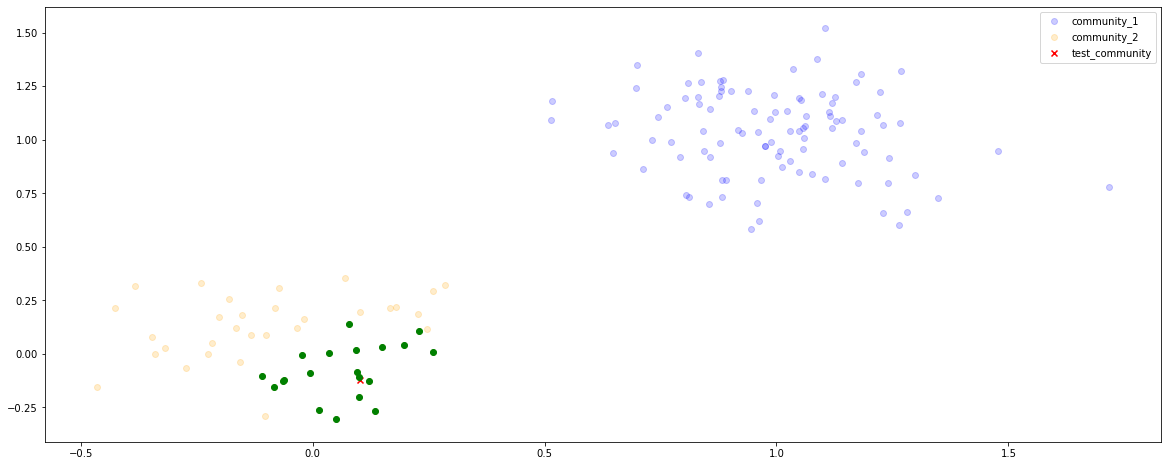

In [281]:
# plot results for two communities and test_community
plt.figure(figsize=(20,8))
plt.scatter(communities[0].get_data()['embeddings'][:,0], communities[0].get_data()['embeddings'][:,1], c='blue', label='community_1', alpha=0.2)
plt.scatter(communities[1].get_data()['embeddings'][:,0], communities[1].get_data()['embeddings'][:,1], c='orange', label='community_2', alpha=0.2)
# test community
plt.scatter(single_test_vector['embeddings'][0], single_test_vector['embeddings'][1], c='red', marker='x', label='test_community')
# closest
for point in k_neighbors.flatten():
    plt.scatter(data['embeddings'][point][0], data['embeddings'][point][1], c='green')

plt.legend()

plt.show()

In [276]:
k_neighbors

array([[105, 124]], dtype=int64)